In [1]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')


In [2]:
dataLoc='/import/silo2/aloe8475/Documents/edamame/edamame/connectivity_data'

In [3]:
from scipy.io import loadmat, savemat
from matplotlib.ticker import LogFormatter 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import networkx as nx
from edamame import *
from tqdm import tqdm_notebook as tqdm
import os
import edamame.core.wires as wires
from IPython.core.debugger import set_trace
# import nct
import bct
import pandas as pd

import pickle 
import _pickle as cPickle
import gzip
import matplotlib.colors as clrs


def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f,encoding="bytes") #change this for python 2
        return loaded_object

2022-01-28 20:00:12,683:INFO:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from edamame.utils import is_notebook, useMyRC
from edamame.draw.draw_graph import draw_graph

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 1e8
from sys import exit
import logging

class graph_movie:
    def __init__(self, network, start=0, end=1, dt=0.01, 
                 interval = 100, figsize=(10,10), 
                 node_data=None,
                 edge_mode='current',
                 edge_data=None,
                 params=dict()):
        useMyRC()
        self.network = network
        self.start = start
        self.end = end
        self.dt = dt
        self.params = params
        self.node_data = node_data
        self.edge_mode = edge_mode
        self.edge_data = edge_data
        self.interval = interval
        
        self.TimeVector = np.arange(start, end, dt)
        self.fig, self.ax = plt.subplots(figsize=figsize)
        if is_notebook():
            plt.close()
        self.fig.set_facecolor((0.6,0.6,0.6))
        self.ax.set_facecolor((0.6,0.6,0.6))
        self.ax.set_title(f't = {start} s')
        self.ax.get_xaxis().set_ticks([])
        self.ax.get_yaxis().set_ticks([])
        if node_data is not None:
            if len(self.TimeVector) != len(node_data):
                logging.warning('Data length does not match!')
                exit()
            params['node_limits'] = [np.min(node_data), np.max(node_data)]
#             cmap = plt.get_cmap('plasma')
#             norm = mpl.colors.Normalize(vmin=params['node_limits'][0],vmax=params['node_limits'][1])
#             cbar1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#             cbar1.set_array([])
#             fig.colorbar(cbar1, ax = self.ax, shrink = 0.8, label = 'Node TE (in + out)')
            
        if edge_data is not None:
            if len(self.TimeVector) != len(edge_data):
                print(len(self.TimeVector))
                print(len(edge_data))
                logging.warning('Data length does not match!')
                exit()
            params['edge_limits'] = [np.min(edge_data), np.max(edge_data)]
#             cmap = plt.get_cmap('OrRd')
#             norm = mpl.colors.Normalize(vmin=params['edge_limits'][0],vmax=params['edge_limits'][1])
#             cbar2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#             cbar2.set_array([])
#             fig.colorbar(cbar2, ax = self.ax, shrink = 1, location = 'bottom', 
#                          label = 'edge TE (both direction)')

        self.compile()

    def compile(self):
        self.movie = animation.FuncAnimation(self.fig, self.update, 
                                             self.TimeVector, interval=self.interval)
        return self.movie                                                                                    

    def update(self, i):
        self.ax.clear()
        temp = self.params.copy()
        temp['network'] = self.network
        temp['ax'] = self.ax
        temp['time'] = i
        idx = np.where(self.TimeVector == i)[0]
        if self.edge_data is not None:
            temp['edge_weight'] = self.edge_data[idx,:].reshape(-1)
        if self.node_data is not None:
            temp['node_weight'] = self.node_data[idx,:].reshape(-1)
#         print(temp['edge_weight'])
        self.ax = draw_graph(**temp)
        self.ax.set_title(f'Network at t = {np.round(i, 3)} s')
        
        return self.ax

    def show(self):
        from IPython.display import HTML
        html = HTML(self.movie.to_jshtml())
        plt.close()
        return html
    
    def save(self, filename=None):
        if filename == None:
            from time import gmtime, strftime
            curr = strftime("%Y%m%d_%H%M", gmtime())
            filename = r'movie/random_movie_' + curr + '.mp4'
        else: 
            filename = r'movie/' + filename
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)
        self.movie.save(filename, writer = writer)
        if is_notebook():
            plt.close()

In [4]:
data=loadmat(dataLoc+'/200nw_1213junctions.mat')

In [5]:
g=nx.from_numpy_array(data['adj_matrix'])

In [40]:
sim=runSim(connectivity__(graph=g),onAmp=3)

Running Simulation : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1068.77it/s]
2022-01-28 20:13:05,883:INFO:First current path [26, 94, 196, 89, 3, 34, 8, 199, 183, 175, 51] formed at time = 0.35 s.


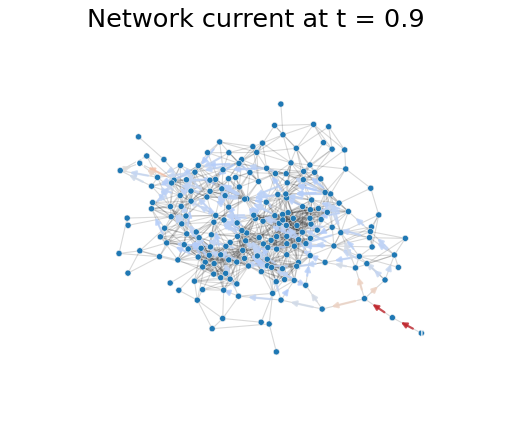

In [85]:
plt.figure()
ax=plt.gca()
draw_graph(sim,this_TimeStamp=900,ax=ax,with_labels=False,node_size=30,edge_cmap=plt.cm.coolwarm,maxWeight=vmax,minWeight=vmin,edge_limits=[vmin,vmax]) #nwnum,newOnAmp,mod
plt.show()

In [62]:
help(draw_graph)

Help on function draw_graph in module edamame.draw.draw_graph:

draw_graph(network, this_TimeStamp=0, ax=None, figsize=(10, 10), edge_mode='current', edge_weight=None, edge_cmap=None, edge_alpha=0.8, edge_limits=None, edge_dashed=True, edge_colorbar=False, node_color='#1f78b4', node_weight=None, node_cmap=None, node_limits=None, node_size=350, node_highlight=array([], dtype=float64), highlight_color='y', with_labels=True, font_color='w', title=None, norm=False, maxWeight=1, minWeight=0, **kwargs)



In [42]:
vmin=np.min(sim.junctionVoltage/sim.junctionResistance)
vmax=np.max(sim.junctionVoltage/sim.junctionResistance)

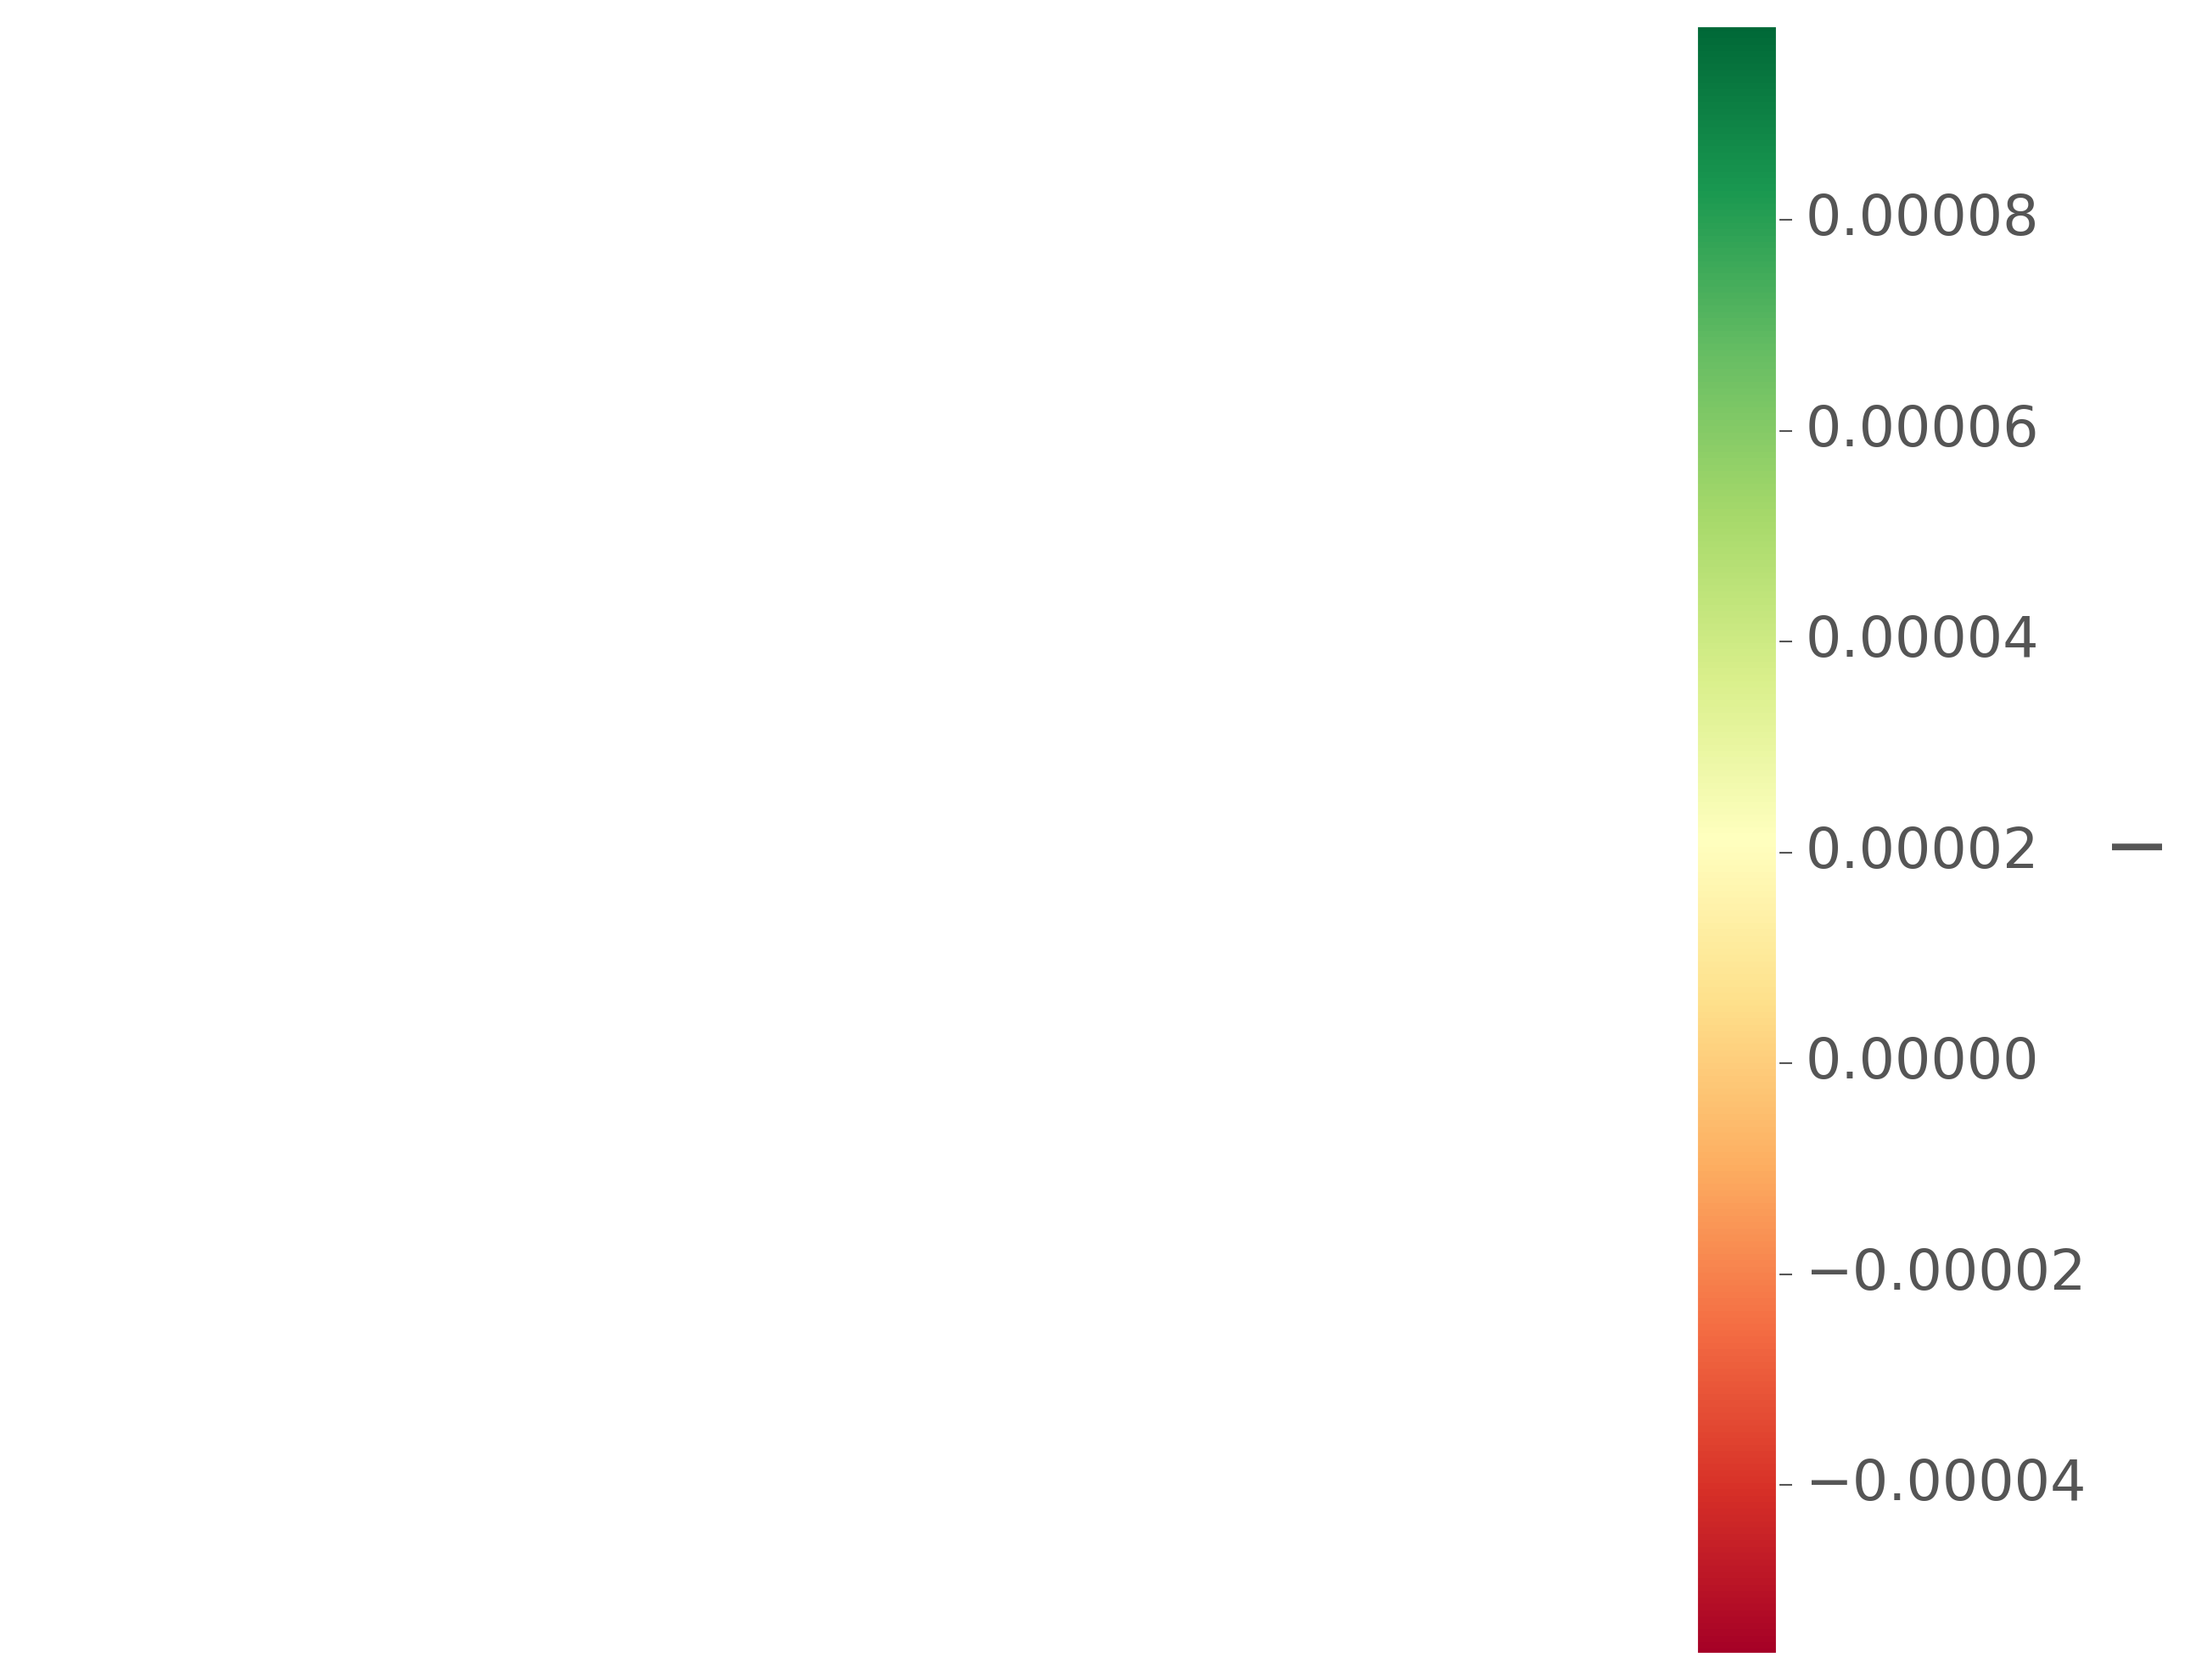

In [124]:
from matplotlib import animation
f,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},frameon=False, figsize=(10, 8), dpi=300)
canvas_width, canvas_height = f.canvas.get_width_height()
ax.axis('off')
cax.axis('off')



sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax,
                    fraction = 0.05, label='I')

def animate(time): #animate
    draw_graph(sim,this_TimeStamp=time,ax=ax,with_labels=False,node_size=30,edge_cmap=plt.cm.RdYlGn,figsize=(20,16),node_highlight=sim.electrodes,dpi=100) #nwnum,newOnAmp,mod
anim = animation.FuncAnimation(f, animate, frames=range(1000)[::20], interval=100, repeat=False)

In [125]:
saveFig='/import/silo2/aloe8475/Documents/Data/Figures/'

In [126]:
currentPath=os.getcwd()
FFwriter = animation.FFMpegWriter()
os.chdir(saveFig)

anim.save('natesh_video.mp4', fps=10, dpi=300,
              progress_callback = lambda i, n: print(f'Saving frame {i+1} of {n}'),)

2022-01-28 22:09:11,023:INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2022-01-28 22:09:11,025:INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3000x2400 -pix_fmt rgba -r 10 -loglevel error -i pipe: -vcodec mpeg4 -y natesh_video.mp4


Saving frame 1 of 50
Saving frame 2 of 50
Saving frame 3 of 50
Saving frame 4 of 50
Saving frame 5 of 50
Saving frame 6 of 50
Saving frame 7 of 50
Saving frame 8 of 50
Saving frame 9 of 50
Saving frame 10 of 50
Saving frame 11 of 50
Saving frame 12 of 50
Saving frame 13 of 50
Saving frame 14 of 50
Saving frame 15 of 50
Saving frame 16 of 50
Saving frame 17 of 50
Saving frame 18 of 50
Saving frame 19 of 50
Saving frame 20 of 50
Saving frame 21 of 50
Saving frame 22 of 50
Saving frame 23 of 50
Saving frame 24 of 50
Saving frame 25 of 50
Saving frame 26 of 50
Saving frame 27 of 50
Saving frame 28 of 50
Saving frame 29 of 50
Saving frame 30 of 50
Saving frame 31 of 50
Saving frame 32 of 50
Saving frame 33 of 50
Saving frame 34 of 50
Saving frame 35 of 50
Saving frame 36 of 50
Saving frame 37 of 50
Saving frame 38 of 50
Saving frame 39 of 50
Saving frame 40 of 50
Saving frame 41 of 50
Saving frame 42 of 50
Saving frame 43 of 50
Saving frame 44 of 50
Saving frame 45 of 50
Saving frame 46 of 